# Mate Detection Results
   
 ### The mate a cup for drininking yerba, a tea popular in the southern cone of South America. Using TensorFlow's Object Detection API we created a program that detects mates in images. The images I used to train the model are open source from Google and Bing. In total, I used 100 images (90 for training and 10 for testing).

 ### https://en.wikipedia.org/wiki/Mate_(drink)

 ### This model uses the ssd_mobilenet_v1_coco (Common Objects in Context) model as a base for transfer learning. 

# Imports

In [182]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [183]:
# This is needed to display the images.
%matplotlib inline

In [184]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [185]:
# the model folder
MODEL_NAME = 'mate_graph'

# The file containing the "frozen" information of the model called a "frozen detection graph.""
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph1.pb'

# This is the path to a file with the labels. 
PATH_TO_LABELS = os.path.join('data', 'object-detection.pbtxt')

## Load a (frozen) Tensorflow model into memory.

In [186]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [187]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [188]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [189]:
# Ten images included for testing. 
# Recommended that test images be no larger than 800 X 800 pixels, in order to see labels. 
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 11) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [190]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

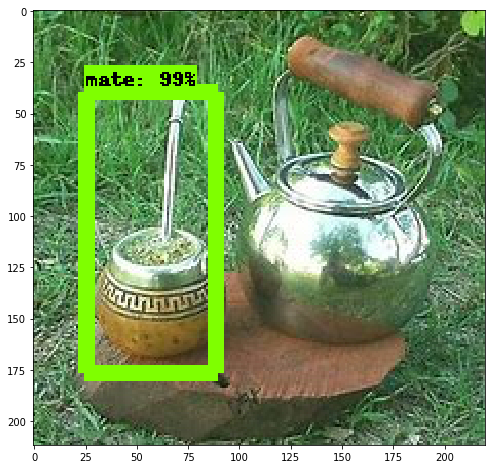

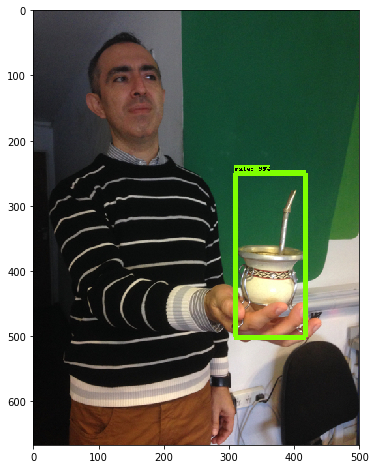

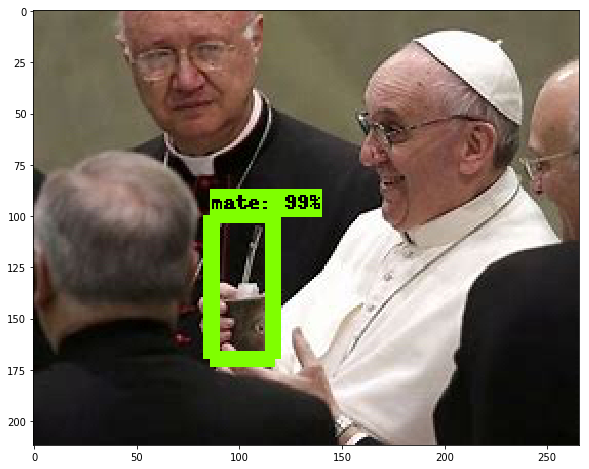

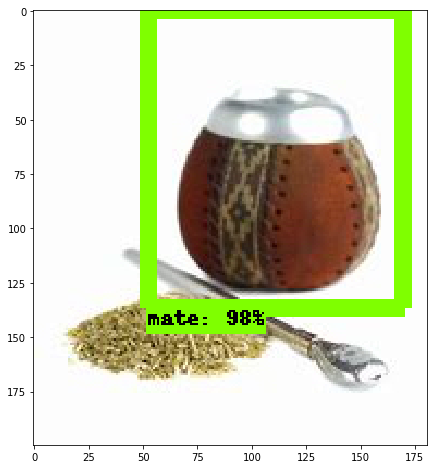

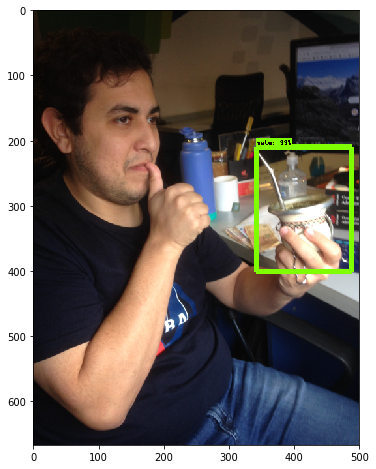

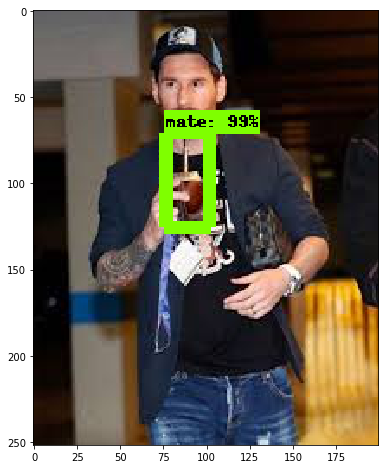

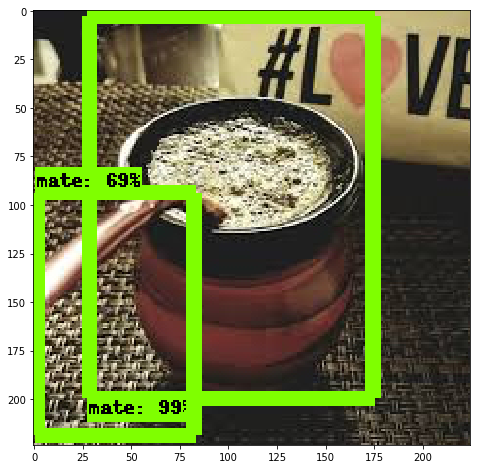

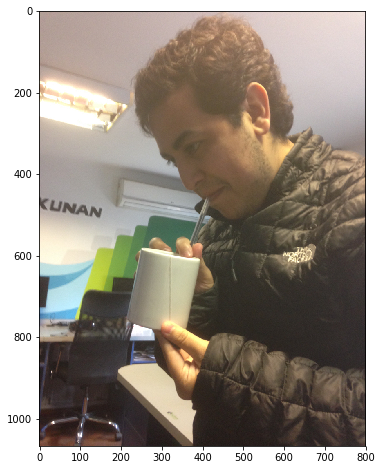

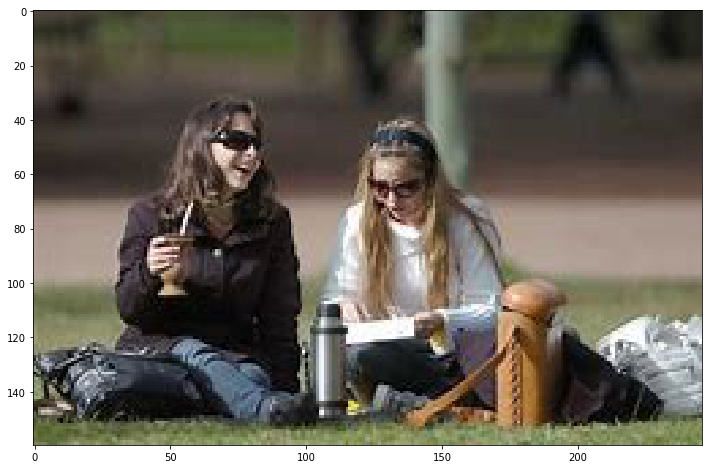

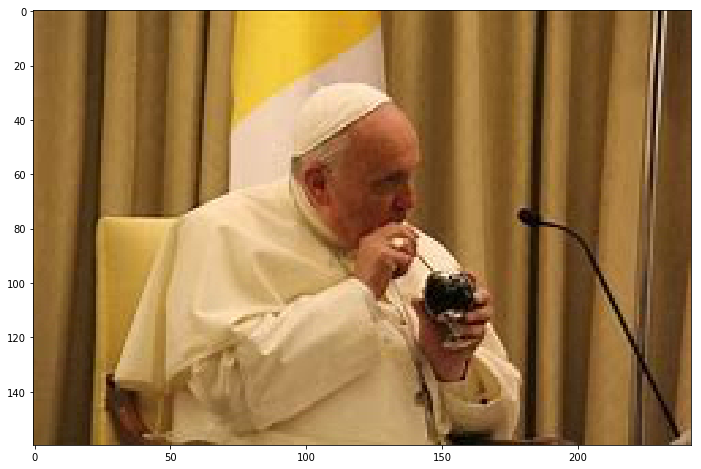

In [191]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [192]:
import pandas as pd
images = [ "image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg", "image5.jpg", "image6.jpg", "image7.jpg", "image8.jpg", "image9.jpg", "image10.jpg"]
content = ['mate and kettle', 'Martin', "Pope Francis", "studio shot", "Gustavo", "Messi", "#Love", "Gustavo w/ coffee cup", "girls at picnic", "Pope Francis #2"]
result = ["TP", "TP", "TP", "TP", "TP", "FN", "TP + FP ", "TN", "FN", "FN"]
accu = [.99, .97, .99, .98, .99, .99, ".99 + .68", 1, 0, 0]
df = pd.DataFrame({'Image' : images,
                  'Result' : result,
                  'Accuracy': accu,
                  'Content': content})

In [193]:
print("FP = false positive, FN = false negative, TP = true positive, TN = true negative")
df

FP = false positive, FN = false negative, TP = true positive, TN = true negative


,Image,Result,Accuracy,Content
0,image1.jpg,TP,0.99,mate and kettle
1,image2.jpg,TP,0.97,Martin
2,image3.jpg,TP,0.99,Pope Francis
3,image4.jpg,TP,0.98,studio shot
4,image5.jpg,TP,0.99,Gustavo
5,image6.jpg,FN,0.99,Messi
6,image7.jpg,TP + FP,.99 + .68,#Love
7,image8.jpg,TN,1,Gustavo w/ coffee cup
8,image9.jpg,FN,0,girls at picnic
9,image10.jpg,FN,0,Pope Francis #2


## Analysis
#### This model was trained on a convolutional neural network;  Our model performed with approximately .75 precision. The model was trained with a GPU using 17,949 steps (iterations) through the NN. The failures of the model, image9.jpg and image10.jpg, are as interesting as the successes. Why didn't the model catch the mates in these photographs? A previous model, trained with many fewer steps, around 350 steps, was able to catch the Pope's mate in image10.jpg, but none of the mates in the other photos. More experimenting with this technology could lead to better precision and performance. 

#### PS. mate_graph/frozen_inference_graph1.pb will also funcion with live streaming video! 